# Exploring Chicago

### Introduction
##### In this project, I'll explore the neighborhoods of Chicago and cluster them to see which neighborhoods are the best for grabbing a drink
##### Hopfully the strangers in town who would like to have some fun in bars will find this useful 

### Data description
##### There are three datasets that will be used in this project:
##### 1. The Chicago neighborhoods and the zip codes;
##### 2. The review results from "Foursquare" API;
##### 3. The bar address (lat & long);

In [3]:
#import required libraries
import numpy as np # library to handle data in a vectorized manner
import requests 
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
!conda install -c conda-forge bs4 --yes
!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
!conda install -c conda-forge lxml --yes


from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from bs4 import BeautifulSoup
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


### Define the URL and scrape request

In [4]:
url = 'https://www.seechicagorealestate.com/chicago-zip-codes-by-neighborhood.php'
results = requests.get(url)

### Check scrape status

In [5]:
results.status_code

200

### Use Beautiful Soup Library to format the response

In [6]:
import bs4
soup = BeautifulSoup(results.content, 'lxml')

In [7]:
a = soup.find_all('td')
length_a = len(a)
length_a
list1 = []
list2 = []
count = 0
for i in a:
    n = []
    for k in i.children:
        n.append(k.string)
    if count%2 == 0:
        list1.append(n)
    else:
        list2.append(n)
    count += 1
for i in range(len(list2)):
    for k in range(list2[i].count(', ')):
        list2[i].remove(', ')

dic = {}
for i in range(len(list1)):
    dic[list1[i][0]] = (list2[i][0])
del dic['\xa0'] 
data1 = pd.DataFrame(dic, index = [0])
data1 = pd.DataFrame(data1.values.T, index=data1.columns, columns=data1.index)


In [8]:
# create dataframe and clean the data
data1.columns = ['zip']
data1 = data1.drop(index=(data1.loc[(data1['zip']=='\xa0')].index))
data1 = data1.drop(index=(data1.loc[(data1['zip']=='Zip Code')].index))


In [9]:
import matplotlib.pyplot as plt # plotting library
!conda install -c conda-forge geocoder --yes
import geocoder

Solving environment: done

# All requested packages already installed.



In [10]:
d2 = []
g = 0
for index, row in data1.iterrows():
    g = geocoder.osm(str(row['zip'])).json
    d2.append([g['lat'],g['lng']])


AttributeError: 'list' object has no attribute 'head'

In [12]:
d2[0]

[41.9022379, -87.6236367]

In [13]:
d3 = {}
n = 0
for index, row in data1.iterrows():
    d3[str(index)] = d2[n]
    n += 1
data3 = pd.DataFrame(d3)
data3 = pd.DataFrame(data3.values.T, index=data3.columns, columns=data3.index)

In [14]:
data3.columns = ['lat', 'lng']
data1['Latitude'] = ''
data1['Longitude'] = ''
for i in range(data1.shape[0]):
    data1["Latitude"][i] = float(data3["lat"][data3[data3.index == data1.index[i]].index][0])
    data1["Longitude"][i] = float(data3["lng"][data3[data3.index == data1.index[i]].index][0])

data1.head()

,zip,Latitude,Longitude
Cathedral District,60611,41.9022,-87.6236
Central Station,60605,41.8659,-87.6099
Dearborn Park,60605,41.8659,-87.6099
Gold Coast,60610,41.8885,-87.6293
Loop,60601,41.886,-87.6246


Libraries imported.


In [193]:
latitude = 41.8
longtitude = -87.6
map_chicago = folium.Map(location=[latitude, longtitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(data1['Latitude'], data1['Longitude'], data1.index):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_chicago)  
    
map_chicago

In [26]:

LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

In [27]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'lat', 
                  'lng', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [28]:
chicago_venues = getNearbyVenues(names=data1.index,
                                   latitudes=data1['Latitude'],
                                   longitudes=data1['Longitude']
                                  )

In [29]:
print(chicago_venues.shape)
chicago_venues.head()

(4726, 7)


,Neighborhood,lat,lng,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Cathedral District,41.902238,-87.623637,Oak Street Beach,41.902309,-87.622511,Beach
1,Cathedral District,41.902238,-87.623637,Spiaggia,41.900718,-87.624286,Italian Restaurant
2,Cathedral District,41.902238,-87.623637,Palm Court at The Drake Hotel,41.900392,-87.623708,Tea Room
3,Cathedral District,41.902238,-87.623637,The Drake Hotel,41.900333,-87.623505,Hotel
4,Cathedral District,41.902238,-87.623637,Fig & Olive,41.901032,-87.625534,Mediterranean Restaurant


In [30]:
print('There are {} uniques categories.'.format(len(chicago_venues['Venue Category'].unique())))

There are 283 uniques categories.


In [31]:
chicago_bars = chicago_venues.loc[chicago_venues['Venue Category'] == 'Bar']

In [32]:
chicago_bars.head()

,Neighborhood,lat,lng,Venue,Venue Latitude,Venue Longitude,Venue Category
56,Cathedral District,41.902238,-87.623637,Eight Bar & Patio,41.901884,-87.628516,Bar
59,Cathedral District,41.902238,-87.623637,Dublin's Bar And Grill,41.901752,-87.628451,Bar
202,Gold Coast,41.888498,-87.629282,Raised Rooftop at Renaissance Hotel,41.886726,-87.628110,Bar
206,Gold Coast,41.888498,-87.629282,Flora Fauna,41.890622,-87.628495,Bar
243,Gold Coast,41.888498,-87.629282,Public House,41.889474,-87.628274,Bar


In [33]:
import numpy as np 
from sklearn.cluster import DBSCAN 
from sklearn.datasets.samples_generator import make_blobs 
from sklearn.preprocessing import StandardScaler 
import matplotlib.pyplot as plt 
%matplotlib inline

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


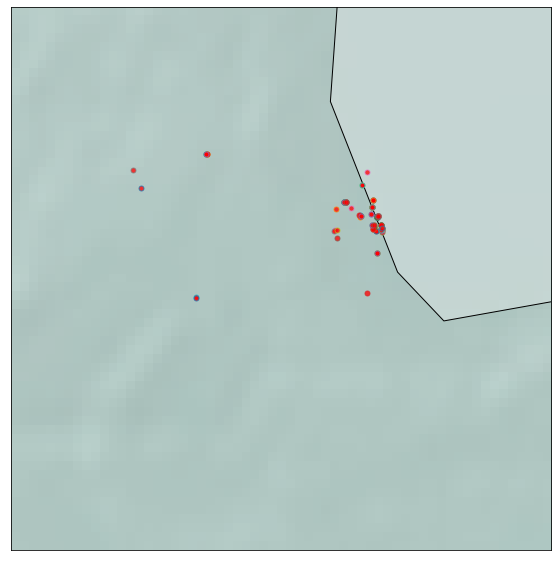

In [38]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = (14,10)

llon=-89#88.56
ulon=-87#87.6
llat=41#41.7
ulat=42.5#42.1

chicago_bars = chicago_bars[(chicago_bars['Venue Longitude'] > llon) & (chicago_bars['Venue Longitude'] < ulon) & (chicago_bars['Venue Latitude'] > llat) &(chicago_bars['Venue Latitude'] < ulat)]

my_map = Basemap(projection='merc',
            resolution = 'l', area_thresh = 1000.0,
            llcrnrlon=llon, llcrnrlat=llat, #min longitude (llcrnrlon) and latitude (llcrnrlat)
            urcrnrlon=ulon, urcrnrlat=ulat) #max longitude (urcrnrlon) and latitude (urcrnrlat)

my_map.drawcoastlines()
my_map.drawcountries()
# my_map.drawmapboundary()
my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.shadedrelief()

# To collect data based on stations        

xs,ys = my_map(np.asarray(chicago_bars['Venue Longitude']), np.asarray(chicago_bars['Venue Latitude']))
chicago_bars['xm']= xs.tolist()
chicago_bars['ym'] =ys.tolist()

#Visualization1
for index,row in chicago_bars.iterrows():
#   x,y = my_map(row.Long, row.Lat)
   my_map.plot(row.xm, row.ym,markerfacecolor =([1,0,0]),  marker='o', markersize= 5, alpha = 0.75)
#plt.text(x,y,stn)
plt.show()

In [44]:
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler
sklearn.utils.check_random_state(1000)
Clus_dataSet = chicago_bars[['xm','ym']]
Clus_dataSet = np.nan_to_num(Clus_dataSet)
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)

# Compute DBSCAN
db = DBSCAN(eps=0.15, min_samples=3).fit(Clus_dataSet)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
chicago_bars["Clus_Db"]=labels

realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels)) 


# A sample of clusters
chicago_bars[["Neighborhood", "Venue Latitude","Venue Longitude","Clus_Db"]].head(5)

,Neighborhood,Venue Latitude,Venue Longitude,Clus_Db
56,Cathedral District,41.901884,-87.628516,0
59,Cathedral District,41.901752,-87.628451,0
202,Gold Coast,41.886726,-87.628110,1
206,Gold Coast,41.890622,-87.628495,1
243,Gold Coast,41.889474,-87.628274,1


In [43]:
set(labels)

{-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # Remove the CWD from sys.path while we load stuff.
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  del sys.path[0]


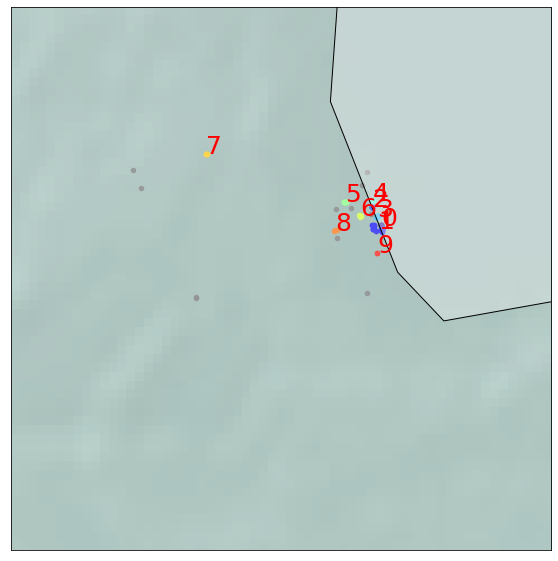

In [47]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = (14,10)

my_map = Basemap(projection='merc',
            resolution = 'l', area_thresh = 1000.0,
            llcrnrlon=llon, llcrnrlat=llat, #min longitude (llcrnrlon) and latitude (llcrnrlat)
            urcrnrlon=ulon, urcrnrlat=ulat) #max longitude (urcrnrlon) and latitude (urcrnrlat)

my_map.drawcoastlines()
my_map.drawcountries()
#my_map.drawmapboundary()
my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.shadedrelief()

# To create a color map
colors = plt.get_cmap('jet')(np.linspace(0.0, 1.0, clusterNum))



#Visualization1
for clust_number in set(labels):
    c=(([0.4,0.4,0.4]) if clust_number == -1 else colors[np.int(clust_number)])
    clust_set = chicago_bars[chicago_bars.Clus_Db == clust_number]                    
    my_map.scatter(clust_set.xm, clust_set.ym, color =c,  marker='o', s= 20, alpha = 0.85)
    if clust_number != -1:
        cenx=np.mean(clust_set.xm) 
        ceny=np.mean(clust_set.ym) 
        plt.text(cenx,ceny,str(clust_number), fontsize=25, color='red',)
        #print ("Cluster "+str(clust_number)+', Avg Temp: '+ str(np.mean(clust_set.Tm)))